In [79]:
""" Import depndencies"""

import pandas as pd
from prophet import Prophet

from os import listdir
from os.path import isfile, join    


In [80]:
""" Extract datasource """

sources = [f for f in listdir("../datasets") if isfile(join("../datasets", f))]

array_dfs = []

for source in sources:
    if source != '.gitkeep':
        array_dfs.append(pd.read_csv(f"../datasets/{source}", low_memory=False))

In [81]:
""" Transform Dataframe """

df = pd.concat(array_dfs, ignore_index=True, sort=False)

df_filtered = df[['Date', 'Consommation']]

df_not_nan_consommation = df_filtered[df_filtered['Consommation'].notna()]

df_sorted = df_not_nan_consommation.sort_values(by='Date')

# aggregation calc mean of Consommation / day
df_final = df_sorted.groupby('Date', as_index=False).agg({'Consommation': 'mean'})

df_data_train = df_final[df_final['Date'] < "2020"]
df_data_test = df_final[df_final['Date'] >= "2020"]

print(df_data_train)
print(df_data_test)



            Date  Consommation
0     2012/01/01  51491.500000
1     2012/01/02  60683.645833
2     2012/01/03  67762.104167
3     2012/01/04  68029.229167
4     2012/01/05  69157.395833
...          ...           ...
2917  2019/12/27  57654.541667
2918  2019/12/28  56572.770833
2919  2019/12/29  59809.791667
2920  2019/12/30  65938.833333
2921  2019/12/31  66632.500000

[2922 rows x 2 columns]
            Date  Consommation
2922  2020/01/01  60785.958333
2923  2020/01/02  64966.583333
2924  2020/01/03  63830.416667
2925  2020/01/04  60931.562500
2926  2020/01/05  60551.500000
...          ...           ...
4013  2022/12/27  53530.250000
4014  2022/12/28  53856.000000
4015  2022/12/29  52290.770833
4016  2022/12/30  52326.729167
4017  2022/12/31  46224.208333

[1096 rows x 2 columns]


/tmp/ipykernel_114145/3900338663.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  decompose.plot().show()


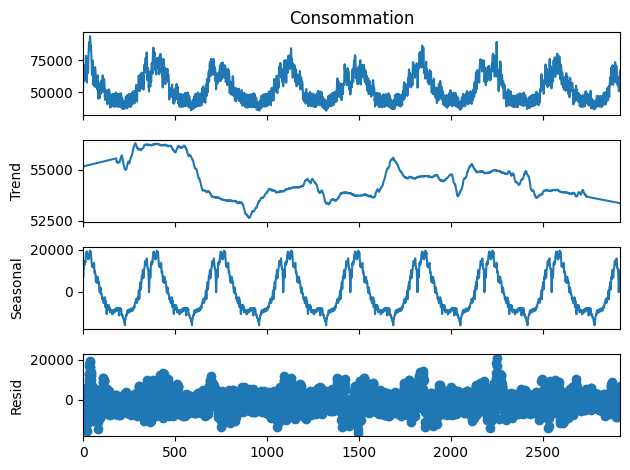

In [82]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df_data_train.Consommation, model='additive', extrapolate_trend='freq', period=365)

decompose.plot().show()

In [83]:
df_train_prophet = df_data_train

# date variable needs to be named "ds" for prophet
df_train_prophet = df_train_prophet.rename(columns={"Date": "ds"})

# target variable needs to be named "y" for prophet
df_train_prophet = df_train_prophet.rename(columns={"Consommation": "y"})

model_prophet  = Prophet()
model_prophet.fit(df_train_prophet)

df_future = model_prophet.make_future_dataframe(periods=1095, freq='D')

df_future

03:09:57 - cmdstanpy - INFO - Chain [1] start processing
03:09:57 - cmdstanpy - INFO - Chain [1] done processing


,ds
0,2012-01-01
1,2012-01-02
2,2012-01-03
3,2012-01-04
4,2012-01-05
...,...
4012,2022-12-26
4013,2022-12-27
4014,2022-12-28
4015,2022-12-29


In [84]:
forecast_prophet = model_prophet.predict(df_future)
forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


,ds,yhat,yhat_lower,yhat_upper
0,2012-01-01,58119.312840,53449.296045,63025.927401
1,2012-01-02,65275.081182,60291.285889,70139.632182
2,2012-01-03,67159.266403,62384.267136,72490.745296
3,2012-01-04,67868.696399,63034.122849,72491.067314
4,2012-01-05,68240.828572,63466.503507,73050.802985
...,...,...,...,...
4012,2022-12-26,59636.278253,53676.189914,65798.960307
4013,2022-12-27,61095.662294,54921.932504,67831.744912
4014,2022-12-28,61397.822471,55119.125269,68013.426997
4015,2022-12-29,61387.239737,55049.112605,68179.240567


In [85]:
from prophet.diagnostics import performance_metrics, cross_validation

df_cv = cross_validation(model_prophet, initial='2190 days', period='30 days', horizon = "365 days")
df_cv
df_p = performance_metrics(df_cv)
df_p


  0%|          | 0/13 [00:00<?, ?it/s]03:09:57 - cmdstanpy - INFO - Chain [1] start processing
03:09:58 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/13 [00:00<00:05,  2.35it/s]03:09:58 - cmdstanpy - INFO - Chain [1] start processing
03:09:58 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 2/13 [00:00<00:04,  2.44it/s]03:09:58 - cmdstanpy - INFO - Chain [1] start processing
03:09:58 - cmdstanpy - INFO - Chain [1] done processing
 23%|██▎       | 3/13 [00:01<00:03,  2.73it/s]03:09:59 - cmdstanpy - INFO - Chain [1] start processing
03:09:59 - cmdstanpy - INFO - Chain [1] done processing
 31%|███       | 4/13 [00:01<00:03,  2.69it/s]03:09:59 - cmdstanpy - INFO - Chain [1] start processing
03:09:59 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 5/13 [00:01<00:02,  2.85it/s]03:09:59 - cmdstanpy - INFO - Chain [1] start processing
03:10:00 - cmdstanpy - INFO - Chain [1] done processing
 46%|████▌     | 6/13 [00:02<00:02,  2.82it/s]03:10:00

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,2.179453e+07,4668.460667,3302.441040,0.056900,0.037453,0.056276,0.746024
1,38 days,2.153707e+07,4640.804877,3275.230293,0.056350,0.037352,0.055735,0.750243
2,39 days,2.112393e+07,4596.078188,3242.732992,0.055645,0.037352,0.055081,0.751379
3,40 days,2.066840e+07,4546.250800,3205.239249,0.054917,0.037243,0.054404,0.755599
4,41 days,2.011846e+07,4485.360919,3163.527295,0.054230,0.037352,0.053763,0.763064
...,...,...,...,...,...,...,...,...
324,361 days,1.975344e+07,4444.483876,3286.002945,0.058787,0.040531,0.057161,0.751217
325,362 days,1.983713e+07,4453.889015,3298.238900,0.059106,0.041468,0.057439,0.749107
326,363 days,1.977021e+07,4446.370007,3295.551224,0.059034,0.040137,0.057380,0.746998
327,364 days,1.956726e+07,4423.489908,3284.080329,0.058740,0.039973,0.057132,0.748134


/tmp/ipykernel_114145/3578963914.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_test['Date'] = pd.to_datetime(df_data_test['Date'])


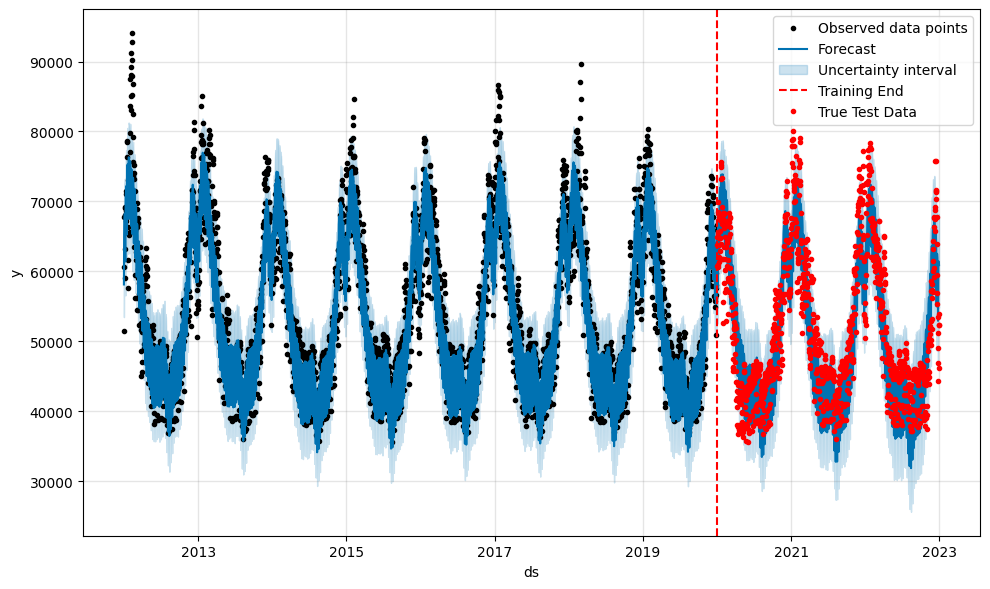

In [86]:
import matplotlib.pyplot as plt

# plot the time series 
forecast_plot = model_prophet.plot(forecast_prophet)

# add a vertical line at the end of the training period
axes = forecast_plot.gca()
last_training_date = forecast_prophet['ds'].iloc[-1095]
axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')

# plot true test data for the period after the red line
df_data_test['Date'] = pd.to_datetime(df_data_test['Date'])
plt.plot(df_data_test['Date'], df_data_test['Consommation'],'ro', markersize=3, label='True Test Data')

# show the legend to distinguish between the lines
plt.legend()